In [1]:
import multiprocessing
num_available_cpus = multiprocessing.cpu_count()

print("Number of available CPUs:", num_available_cpus)

import sys

import math
import time
import tqdm

import numpy as np
import scipy as sp
from scipy import stats

import itertools
import logging
import matplotlib.pyplot as plt

import pandas as pd
import h5py

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import torch.utils.data as utils

from argparse import ArgumentParser
import re

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

Number of available CPUs: 80


In [2]:
from nflows.flows.base import Flow
from nflows.flows.autoregressive import MaskedAutoregressiveFlow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseQuadraticAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [3]:
num_bkg_batches = 1
num_sig_batches = 20

Mjj_cut = 1200
pt_cut = 550
eta_cut = None
box_cox = False

In [4]:
num_features = 10
NS_hidden_features = 40
flow_type = 'NSQUAD' #Options are 'MAF', 'Planar' (not recommended), 'NSQUAD', and 'NSRATQUAD'

In [5]:
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

torch.set_num_threads(num_available_cpus)

print("Number of threads:", torch.get_num_threads())
print("Number of interop threads:", torch.get_num_interop_threads())

Device = cuda:0
Number of threads: 80
Number of interop threads: 80


In [6]:
bkg_data = np.array([])

for batch_number in range(num_bkg_batches): 
    train_batch = "/nobackup/users/myunus/CASE_samples/BB_batch%s.h5" % (batch_number)
    f = h5py.File(train_batch, "r")
    
    if batch_number == 0: 
        print("Keys: %s" % f.keys())
    
    jet_kinematics = f['jet_kinematics']
    jet1_extraInfo = f['jet1_extraInfo']
    jet2_extraInfo = f['jet2_extraInfo']
    truth_label = f['truth_label']

    np.seterr(invalid = 'ignore')

    delta_eta = jet_kinematics[:,1]

    Mjj = np.reshape(jet_kinematics[:,0], (-1,1))
    Mj1 = np.reshape(jet_kinematics[:,5], (-1,1))
    Mj2 = np.reshape(jet_kinematics[:,9], (-1,1))

    jet1_pt = np.reshape(jet_kinematics[:,2], (-1,1))
    jet2_pt = np.reshape(jet_kinematics[:,6], (-1,1))

    jet1_tau1 = np.reshape(jet1_extraInfo[:,0], (-1,1))
    jet1_tau2 = np.reshape(jet1_extraInfo[:,1], (-1,1))
    jet1_tau3 = np.reshape(jet1_extraInfo[:,2], (-1,1))
    jet1_tau4 = np.reshape(jet1_extraInfo[:,3], (-1,1))
    #jet1_btagscore = np.reshape(jet1_extraInfo[:,5],(-1,1))
    jet1_numpfconst = np.reshape(jet1_extraInfo[:,6],(-1,1))

    jet1_tau21 = jet1_tau2 / jet1_tau1
    jet1_tau32 = jet1_tau3 / jet1_tau2
    jet1_tau43 = jet1_tau4 / jet1_tau3
    jet1_sqrt_tau21 = np.sqrt(jet1_tau21) / jet1_tau1

    jet2_tau1 = np.reshape(jet2_extraInfo[:,0], (-1,1))
    jet2_tau2 = np.reshape(jet2_extraInfo[:,1], (-1,1))
    jet2_tau3 = np.reshape(jet2_extraInfo[:,2], (-1,1))
    jet2_tau4 = np.reshape(jet2_extraInfo[:,3], (-1,1))
    #jet2_btagscore = np.reshape(jet2_extraInfo[:,5],(-1,1))
    jet2_numpfconst = np.reshape(jet2_extraInfo[:,6],(-1,1))

    jet2_tau21 = jet2_tau2 / jet2_tau1
    jet2_tau32 = jet2_tau3 / jet2_tau2
    jet2_tau43 = jet2_tau4 / jet2_tau3
    jet2_sqrt_tau21 = np.sqrt(jet2_tau21) / jet2_tau1

    truth_label = truth_label[:]
    
    data = np.concatenate((jet1_tau21, jet1_tau32, jet1_tau43, jet1_sqrt_tau21, jet1_numpfconst, 
                       jet2_tau21, jet2_tau32, jet2_tau43, jet2_sqrt_tau21, jet2_numpfconst), axis=1)

    bkg_indices = np.where((truth_label == 0) 
                              & (Mjj > Mjj_cut) 
                              & (Mj1 > 0)
                              & (Mj2 > 0)
                              & (jet1_pt > pt_cut) 
                              & (jet2_pt > pt_cut)
                              & (np.isfinite(jet1_tau21))
                              & (np.isfinite(jet1_tau32))
                              & (np.isfinite(jet1_tau43))
                              & (np.isfinite(jet1_sqrt_tau21))
                              & (np.isfinite(jet2_tau21))
                              & (np.isfinite(jet2_tau32))
                              & (np.isfinite(jet2_tau43))
                              & (np.isfinite(jet2_sqrt_tau21)))[0]

    if eta_cut is not None: 
        bkg_eta_indices = np.where((np.abs(delta_eta) < eta_cut))[0]
        bkg_indices = np.intersect1d(bkg_indices, bkg_eta_indices)

    if batch_number == 0: 
        bkg_data = data[bkg_indices]
    else: 
        bkg_data = np.concatenate((bkg_data, data[bkg_indices]), axis=0)
    
    if box_cox: 
        
        transformed_data = np.zeros(bkg_data.shape)
        best_lambdas = []
        for col in range(num_features): 
            boxcox_col, best_lambda = stats.boxcox(bkg_data[:,col] + np.abs(np.min(bkg_data[:,col])) + 1)
            transformed_data[:,col] = boxcox_col
            best_lambdas.append(best_lambda)

        print(best_lambdas)

        bkg_data = transformed_data

Keys: <KeysViewHDF5 ['event_info', 'jet1_PFCands', 'jet1_extraInfo', 'jet2_PFCands', 'jet2_extraInfo', 'jet_kinematics', 'truth_label']>


(196837, 10)


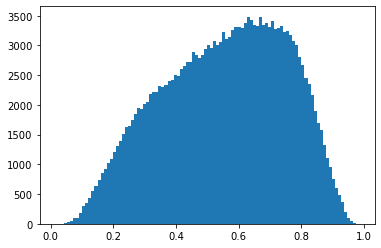

In [7]:
print(bkg_data.shape)

plot_var = 0
plt.hist(bkg_data[:,plot_var], bins=100)
plt.show()

In [8]:
bkg_mean = []
bkg_std = []

for index in range(bkg_data.shape[1]):
    mean = np.mean(bkg_data[:,index])
    std = np.std(bkg_data[:,index])
    bkg_mean.append(mean)
    bkg_std.append(std)
    bkg_data[:,index] = (bkg_data[:,index]-mean)/std

In [9]:
bkg_mean

[0.5546581,
 0.77264345,
 0.84187394,
 9.535129,
 56.12205,
 0.7016144,
 0.7999982,
 0.834374,
 20.80692,
 41.194126]

In [10]:
bkg_std

[0.19600613,
 0.11156813,
 0.06708213,
 9.3801985,
 19.715466,
 0.1466012,
 0.083346665,
 0.06478198,
 15.283091,
 15.936338]

In [11]:
bkg_labels = np.zeros((bkg_data.shape[0], 1))
bkg_data = np.concatenate((bkg_data, bkg_labels), axis=1)
print(bkg_data.shape)

(196837, 11)


In [12]:
sig_data = np.array([])

for batch_number in range(num_sig_batches): 
    train_batch = "/nobackup/users/myunus/CASE_samples/BB_batch%s.h5" % (batch_number)
    f = h5py.File(train_batch, "r")
    
    if batch_number == 0: 
        print("Keys: %s" % f.keys())
    
    jet_kinematics = f['jet_kinematics']
    jet1_extraInfo = f['jet1_extraInfo']
    jet2_extraInfo = f['jet2_extraInfo']
    truth_label = f['truth_label']

    np.seterr(invalid = 'ignore')

    delta_eta = jet_kinematics[:,1]

    Mjj = np.reshape(jet_kinematics[:,0], (-1,1))
    Mj1 = np.reshape(jet_kinematics[:,5], (-1,1))
    Mj2 = np.reshape(jet_kinematics[:,9], (-1,1))

    jet1_pt = np.reshape(jet_kinematics[:,2], (-1,1))
    jet2_pt = np.reshape(jet_kinematics[:,6], (-1,1))

    jet1_tau1 = np.reshape(jet1_extraInfo[:,0], (-1,1))
    jet1_tau2 = np.reshape(jet1_extraInfo[:,1], (-1,1))
    jet1_tau3 = np.reshape(jet1_extraInfo[:,2], (-1,1))
    jet1_tau4 = np.reshape(jet1_extraInfo[:,3], (-1,1))
    #jet1_btagscore = np.reshape(jet1_extraInfo[:,5],(-1,1))
    jet1_numpfconst = np.reshape(jet1_extraInfo[:,6],(-1,1))

    jet1_tau21 = jet1_tau2 / jet1_tau1
    jet1_tau32 = jet1_tau3 / jet1_tau2
    jet1_tau43 = jet1_tau4 / jet1_tau3
    jet1_sqrt_tau21 = np.sqrt(jet1_tau21) / jet1_tau1

    jet2_tau1 = np.reshape(jet2_extraInfo[:,0], (-1,1))
    jet2_tau2 = np.reshape(jet2_extraInfo[:,1], (-1,1))
    jet2_tau3 = np.reshape(jet2_extraInfo[:,2], (-1,1))
    jet2_tau4 = np.reshape(jet2_extraInfo[:,3], (-1,1))
    #jet2_btagscore = np.reshape(jet2_extraInfo[:,5],(-1,1))
    jet2_numpfconst = np.reshape(jet2_extraInfo[:,6],(-1,1))

    jet2_tau21 = jet2_tau2 / jet2_tau1
    jet2_tau32 = jet2_tau3 / jet2_tau2
    jet2_tau43 = jet2_tau4 / jet2_tau3
    jet2_sqrt_tau21 = np.sqrt(jet2_tau21) / jet2_tau1

    truth_label = truth_label[:]
    
    data = np.concatenate((jet1_tau21, jet1_tau32, jet1_tau43, jet1_sqrt_tau21, jet1_numpfconst, 
                       jet2_tau21, jet2_tau32, jet2_tau43, jet2_sqrt_tau21, jet2_numpfconst), axis=1)

    sig_indices = np.where((truth_label == 2) 
                              & (Mjj > Mjj_cut) 
                              & (jet1_pt > pt_cut) 
                              & (jet2_pt > pt_cut)
                              & (np.isfinite(jet1_tau21))
                              & (np.isfinite(jet1_tau32))
                              & (np.isfinite(jet1_tau43))
                              & (np.isfinite(jet1_sqrt_tau21))
                              & (np.isfinite(jet2_tau21))
                              & (np.isfinite(jet2_tau32))
                              & (np.isfinite(jet2_tau43))
                              & (np.isfinite(jet2_sqrt_tau21)))[0]

    if eta_cut is not None: 
        sig_eta_indices = np.where((np.abs(delta_eta) < eta_cut))[0]
        sig_indices = np.intersect1d(sig_indices, sig_eta_indices)

    if batch_number == 0: 
        sig_data = data[sig_indices]
    else: 
        sig_data = np.concatenate((sig_data, data[sig_indices]), axis=0)
    
    if box_cox: 
        
        transformed_data = np.zeros(sig_data.shape)
        best_lambdas = []
        for col in range(num_features): 
            boxcox_col, best_lambda = stats.boxcox(sig_data[:,col] + np.abs(np.min(sig_data[:,col])) + 1)
            transformed_data[:,col] = boxcox_col
            best_lambdas.append(best_lambda)

        print(best_lambdas)

        sig_data = transformed_data

Keys: <KeysViewHDF5 ['event_info', 'jet1_PFCands', 'jet1_extraInfo', 'jet2_PFCands', 'jet2_extraInfo', 'jet_kinematics', 'truth_label']>


(13489, 10)


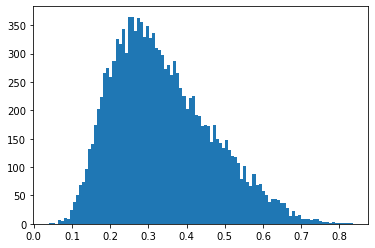

In [13]:
print(sig_data.shape)

plot_var = 0
plt.hist(sig_data[:,plot_var], bins=100)
plt.show()

In [14]:
sig_mean = []
sig_std = []

for index in range(sig_data.shape[1]):
    mean = np.mean(sig_data[:,index])
    std = np.std(sig_data[:,index])
    sig_mean.append(mean)
    sig_std.append(std)
    sig_data[:,index] = (sig_data[:,index]-mean)/std

In [15]:
sig_mean

[0.337454,
 0.7443578,
 0.82764494,
 6.859797,
 39.520794,
 0.3976583,
 0.75373393,
 0.8245147,
 9.298458,
 38.39751]

In [16]:
sig_std

[0.12913826,
 0.13577673,
 0.073178515,
 2.6844316,
 11.539939,
 0.15362568,
 0.11772301,
 0.07234418,
 5.4005322,
 10.195707]

In [17]:
sig_labels = np.ones((sig_data.shape[0], 1))
sig_data = np.concatenate((sig_data, sig_labels), axis=1)
print(sig_data.shape)

(13489, 11)


In [18]:
supervised_data = np.concatenate((bkg_data, sig_data), axis=0)
np.random.shuffle(supervised_data)
supervised_data_NL = supervised_data[:,:-1] # NL stands for No Labels
supervised_labels = supervised_data[:,-1]
print(supervised_data.shape)
print(supervised_data_NL.shape)
print(supervised_labels.shape)
print(supervised_data[:25])

(210326, 11)
(210326, 10)
(210326,)
[[-0.52414531  0.25217831  1.30053985 -0.75220406 -0.30509642  0.29986814
  -0.64156491  1.20756948 -0.4145996   1.13797784  1.        ]
 [ 0.98827457 -0.72808903  0.15251926 -0.1935311  -0.25979865  1.29742754
   0.11645433  1.66777408  0.00758317  0.30156702  0.        ]
 [ 1.55610991  0.08493537 -1.78570521  0.60062677  1.16804826  0.75979221
   0.64668119 -0.77485025  0.94143522  0.15717296  1.        ]
 [-0.47954512  0.34129453  0.04568478  0.0197563  -0.66557145  0.85714394
   0.17852215  1.34769738 -0.67957109  1.05456305  0.        ]
 [ 0.5076986   0.58918178 -0.53949374  1.36378789 -1.52783871 -1.65008521
   0.33861727  0.52298397 -0.19002411 -1.0161761   0.        ]
 [ 0.92704004  1.21343994  0.95871043  0.34606135 -0.36124185  0.3778615
   0.58511293  0.70430058 -0.11612381 -0.3259297   0.        ]
 [-0.42214414 -3.191396    0.71637303 -0.87840831  0.39958218  0.00902844
  -3.29295039  0.56744224 -0.383405   -0.51417869  0.        ]
 [-0.8

In [19]:
classifier = MLPClassifier(hidden_layer_sizes = (30,20))
classifier.fit(supervised_data_NL, supervised_labels)

MLPClassifier(hidden_layer_sizes=(30, 20))

In [20]:
supervised_predict_proba = classifier.predict_proba(supervised_data_NL)
print(supervised_labels.shape)
print(supervised_predict_proba.shape)
fpr, tpr, _ = roc_curve(y_true = supervised_labels, y_score = supervised_predict_proba[:,1], pos_label = 1)
print(fpr)
print(tpr)

(210326,)
(210326, 2)
[0.         0.         0.         ... 0.67525414 0.67525414 1.        ]
[0.         0.008822   0.01045296 ... 0.99992587 1.         1.        ]


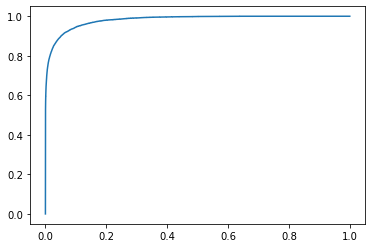

0.9813995009102916


In [21]:
plt.plot(fpr, tpr)
plt.show()
AUC = roc_auc_score(y_true = supervised_labels, y_score = supervised_predict_proba[:,1])
print(AUC)